In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_all_alphas, weather_all_costs, prediction_humidity, model_02, validate, dengue_weather

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


running model_02
getting cost from nweek ahead
getting bounded alphas with params for all params...
done getting alphas ...
prediction for humidity
dengue weather


In [2]:
def seperate_train_test(all_data, train_data, peak):
    peak_for_txt = peak -10
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,peak_for_txt,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,peak_for_txt,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

def plot_all_predictions(LAG, real, train, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real.cases,label='real')
    graph_title = "%s's Dengue Prediction with Weather Data"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    real_max = real.cases.max()
    train_max = train.cases.max()
    peak = max(real_max,train_max)
    seperate_train_test(real,train,peak)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,peak/2,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
#     plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def show_predictions(params, real, train, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, AVGRH_WEEKS = params[0], params[1], params[2], params[3]
    
    predictions_to_plot = prediction_humidity.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS,
        RAIN_WEEKS,
        AVGRH_WEEKS,
        real,
        ws,
        province)
    
    plot_all_predictions(LAG, 
                         real,
                         train,
                         province,
                         [1,2,4,8,16],
                         predictions_to_plot)


In [3]:
all_weather = pd.read_csv("weather01-16.csv")
all_weather.stn_name = all_weather.stn_name.apply(dengue_weather.remove_space)
all_dengue = pd.read_csv("all-dengues.csv")
all_dengue = all_dengue.rename(columns = {'จังหวัด' : 'province'})

In [5]:
                       # province_dengue: province_weather
provinces_to_predict = {"Bangkok":"BangkokMetropolis",
                        "PrachuapKhiriKhan":"PrachuapKhiriKhan",
                        "PhraNakhonSiAyutthaya":"AyuttayaAgromet", 
                        "Songkhla":"PhatthalungAgromet", 
                        "Ratchaburi":"Ratchaburi", 
                        "ChonBuri":"ChonBuri", 
                        "NongKhai":"NongKhai",
                        "SakonNakhon":"SakonNakhonAgromet",
                        "ChiangMai":"ChiangMai",
                        "ChiangRai":"ChiangRai"}

# provinces_to_predict = {"Pathumthani":"PathumthaniAgromet",
#                         "SamutPrakan":"PilotStation",
#                         "NakhonPathom":"KamphaengSaenAgromet", 
#                         "MahaSarakham":"KosumPhisai",  
#                         "Pattani":"PattaniAirport", 
#                         "SuratThani":"SuratThaniAgromet"}

province_data = {}
for province_for_dengue in provinces_to_predict:
    province_for_weather = provinces_to_predict.get(province_for_dengue)
    print province_for_dengue, province_for_weather
    
    province_data_to_predict = dengue_weather.get_dengue_weather_by_province(
                                                                    province_for_dengue, 
                                                                    province_for_weather, 
                                                                    all_dengue, 
                                                                    all_weather)
    province_data[province_for_dengue] = province_data_to_predict
    
# province data is dictionary of province to its train and real data, idx 0 and 1
# ex --> province_data.get('Bangkok')[0]

dengue weather
Bangkok BangkokMetropolis
Ratchaburi Ratchaburi
PhraNakhonSiAyutthaya AyuttayaAgromet
NongKhai NongKhai
SakonNakhon SakonNakhonAgromet
PrachuapKhiriKhan PrachuapKhiriKhan
Songkhla PhatthalungAgromet
ChiangMai ChiangMai
ChonBuri ChonBuri
ChiangRai ChiangRai


### perform error testing on test data

In [61]:
def get_distances(LAG, all_predictions, real):

    def distance(prediction, real):
        all_residual = prediction - real
        return abs(all_residual)

    weeks = [1,2,4,8,16]
    ret = []
    for idx,prediction in enumerate(all_predictions):
        cur_pred = np.array(prediction)
        # compare with real
        # doesnt take into the accout of the predicted week(s)
        cur_pred_range = cur_pred[:-weeks[idx]]
        real_range = real.cases[LAG+weeks[idx]:]
        ret.append(distance(cur_pred_range,real_range))

    return ret

In [183]:
chosen_ws = glob.glob("province-ws-*.csv")
test_err = []
for ws_set_file in chosen_ws:
    raw_cur_ws = pd.read_csv(ws_set_file).T
    cur_ws = np.array(raw_cur_ws)[0]
    cur_province = ws_set_file[16:-4]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    cur_test = province_data[cur_province][2]
    print "cur_province", cur_province
    print "cur_test", len(cur_test)
    
    predictions_to_validate = prediction_humidity.get_predictions(
        19,9,15,1,
        cur_test,
        cur_ws)
    
    cur_test_err = get_distances(
        19,
        predictions_to_validate,
        cur_test)
    
    test_err.append(cur_test_err)
    
#     show_predictions(
#                     [19,9,15,1],
#                     cur_real,
#                     cur_train,
#                     cur_province,
#                     cur_ws)

cur_province ChiangMai
cur_test 262
cur_province ChiangRai
cur_test 262
cur_province ChonBuri
cur_test 262
cur_province NongKhai
cur_test 262
cur_province PhraNakhonSiAyutthaya
cur_test 262
cur_province PrachuapKhiriKhan
cur_test 262
cur_province Ratchaburi
cur_test 262
cur_province SakonNakhon
cur_test 262
cur_province Songkhla
cur_test 262


In [184]:
# for i in range(len(test_err)):
#     print len(test_err[i])

arr = []
for i_idx in range(len(test_err[0])):
    tmp = []
    for j_idx in range(len(test_err)):
#         print len(test_err[j_idx][i_idx]), test_err[j_idx][i_idx][-1]
        tmp.append(test_err[j_idx][i_idx])
    concat_tmp = np.append([],tmp)
    arr.append(concat_tmp)
    
predicted_weeks = pd.DataFrame(arr).T
predicted_weeks.columns = ['1_week','2_weeks','4_weeks','8_weeks','16_weeks']

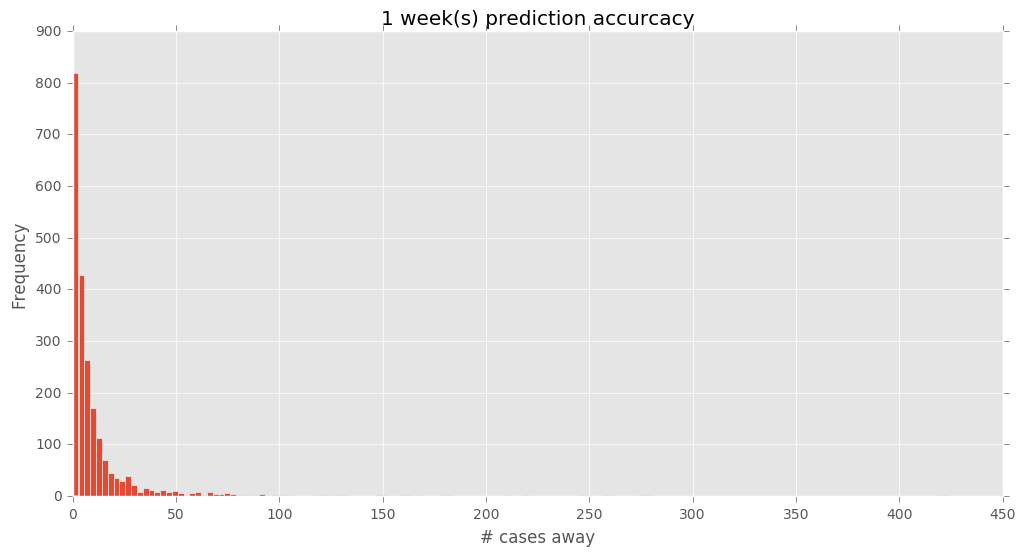

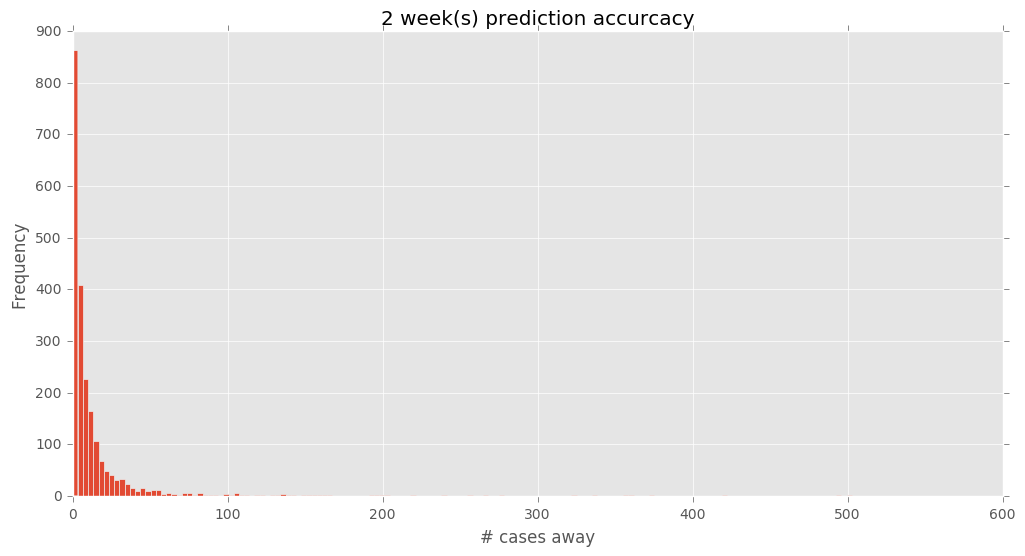

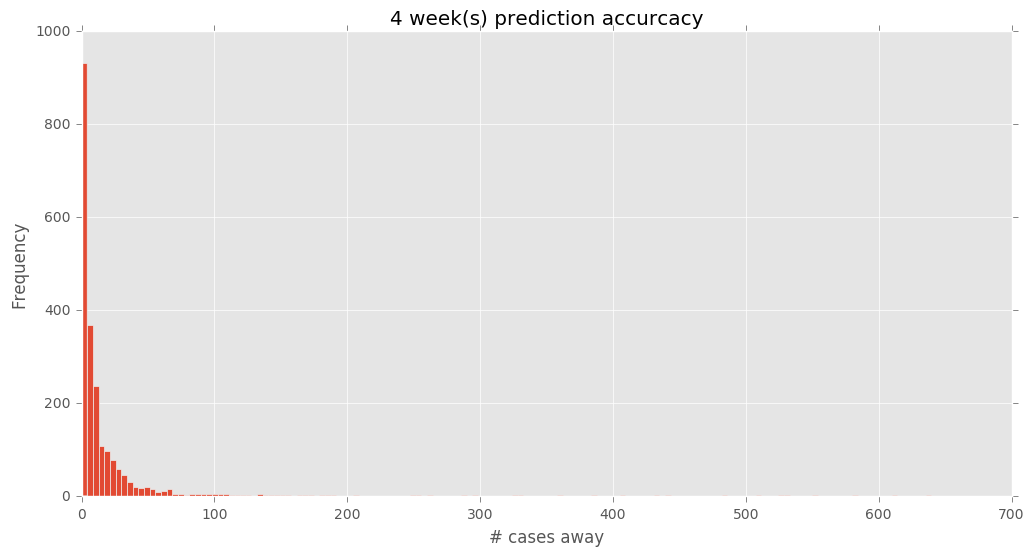

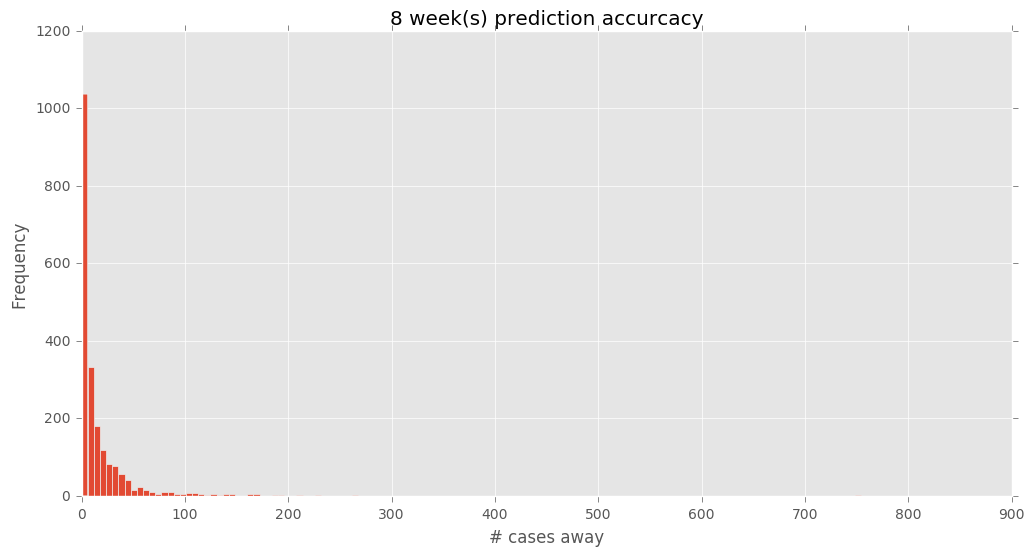

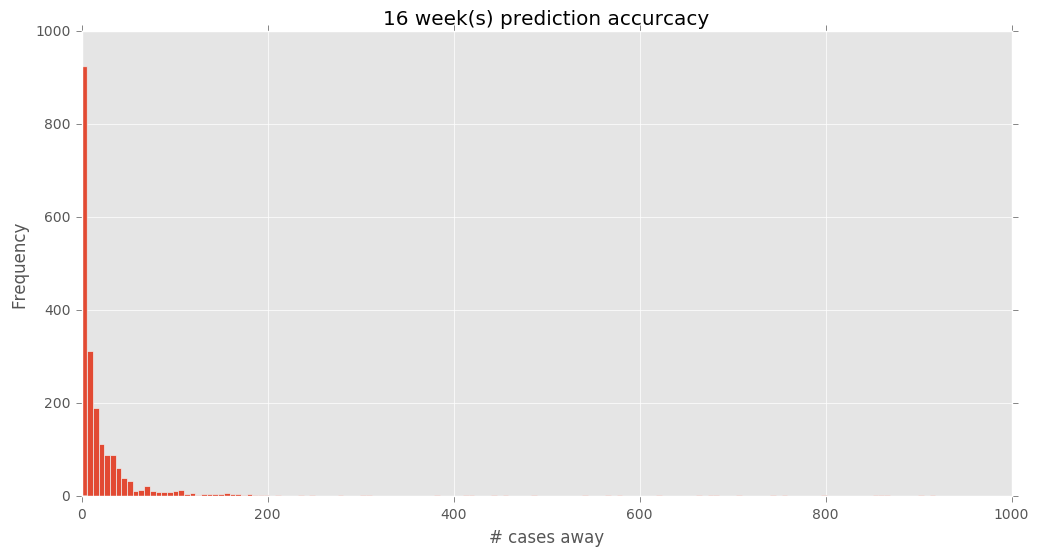

In [189]:
for i in range(0,5):
    plt.figure(figsize=(12,6))
    title = "%d week(s) prediction accurcacy on test"%(2**i)
    predicted_weeks.iloc[:,i].plot(kind='hist',bins=150,title=title)
    plt.xlabel("# cases away")